In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LogNorm
from scipy.linalg import expm, fractional_matrix_power

from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster

from sklearn.metrics import adjusted_mutual_info_score as ami

from scipy.stats import zscore

from tqdm.auto import tqdm

import networkx as nx
#from networkx.community import louvain_communities
import igraph as ig

from utils.Multiscale.load_data import load_dict
from utils.Multiscale.multiscale_functions import laplacian_matrix
from netneurotools import plotting, cluster
from netneurotools.metrics import communicability_bin, communicability_wei

import utils.CommonFunctions as cf
import utils.plotter as plotter
from utils import distance

plt.rcParams.update({'font.size': 16})
#plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'font.family': 'serif'})

# Data visualization

In [2]:
from enigmatoolbox.datasets import load_sc, load_fc

In [24]:
### Load data
parcellation = 'schaefer_100'
sc, sc_ctx_labels, _, _ = load_sc(parcellation)
fc, _, _, _ = load_fc(parcellation) # fc matric is z-scored

### Correct SC
sc = np.log10(sc)
sc[np.isinf(sc)] = 0
sc[np.isnan(sc)] = 0

/tmp/ipykernel_68151/3227108190.py:7: RuntimeWarning: divide by zero encountered in log10
  sc = np.log10(sc)
/tmp/ipykernel_68151/3227108190.py:7: RuntimeWarning: invalid value encountered in log10
  sc = np.log10(sc)


In [4]:
### Convert labels to RSN
rsn = [tmp.split('_')[2] for tmp in sc_ctx_labels]

### Convert RSN to numbers
networks = np.unique(rsn)

### Create dictionary for mapping to numbers
rsn_dict = dict([(y,x+1) for x,y in enumerate(sorted(set(rsn)))])

### Get true communities
comms_true = [rsn_dict[tmp] for tmp in rsn]
comms_true = np.array(comms_true)-1

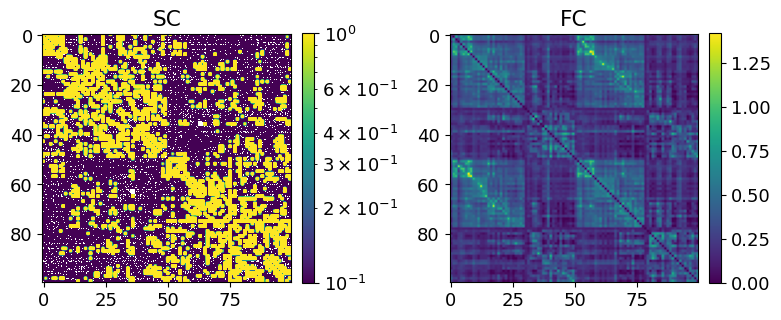

In [7]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(sc, norm=LogNorm(vmin=1e-1, vmax=1))
#plt.imshow(sc)
plt.colorbar(fraction=0.046, pad=0.04)
#plt.axis('off')
plt.title('SC')

plt.subplot(1,2,2)
plt.imshow(fc)
plt.colorbar(fraction=0.046, pad=0.04)
#plt.axis('off')
plt.title('FC')

plt.tight_layout()
plt.show()

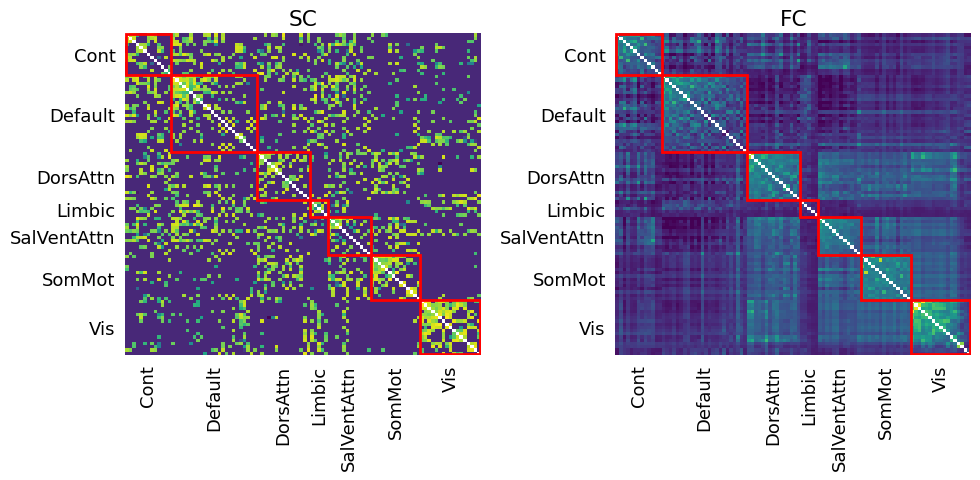

In [7]:
plt.figure(figsize=(10,5))

ax1 = plt.subplot(1,2,1)
plotting.plot_mod_heatmap(sc, comms_true, ax=ax1, cbar=False, xlabels=networks, ylabels=networks, edgecolor='red')
plt.title('SC')

ax2 = plt.subplot(1,2,2)
plotting.plot_mod_heatmap(fc, comms_true, ax=ax2, cbar=False, xlabels=networks, ylabels=networks, edgecolor='red')
plt.title('FC')

plt.tight_layout()
plt.show()

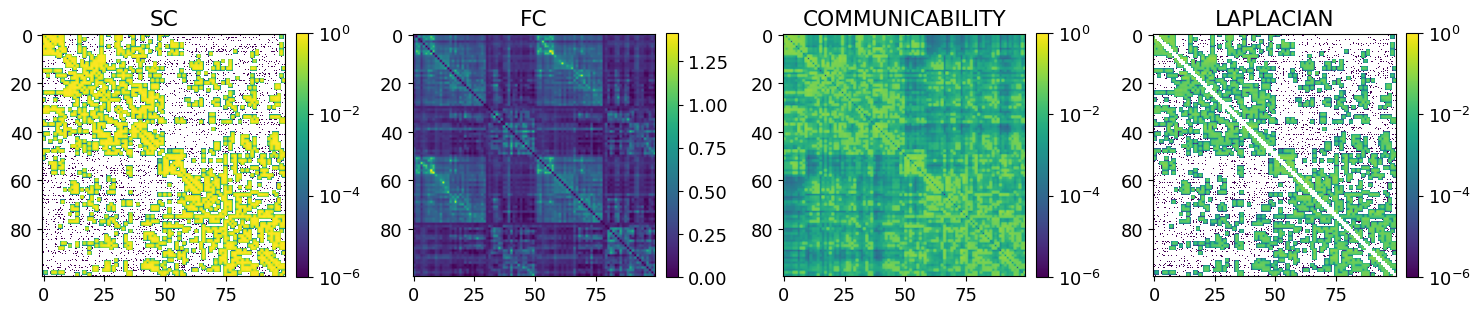

In [191]:
plt.figure(figsize=(15,15))

plt.subplot(1,4,1)
plt.imshow(sc, norm=LogNorm(vmin=1e-6, vmax=1))
plt.colorbar(fraction=0.046, pad=0.04)
#plt.axis('off')
plt.title('SC')

plt.subplot(1,4,2)
plt.imshow(fc)
plt.colorbar(fraction=0.046, pad=0.04)
#plt.axis('off')
plt.title('FC')

plt.subplot(1,4,3)
plt.imshow(communicability_wei(sc), norm=LogNorm(vmin=1e-6, vmax=1))
plt.colorbar(fraction=0.046, pad=0.04)
#plt.axis('off')
plt.title('COMMUNICABILITY')

plt.subplot(1,4,4)
plt.imshow(-laplacian_matrix(sc), norm=LogNorm(vmin=1e-6, vmax=1))
plt.colorbar(fraction=0.046, pad=0.04)
#plt.axis('off')
plt.title('LAPLACIAN')

plt.tight_layout()
plt.show()

# Compute structural and communicability communities

In [19]:
def community_detection(mat, method, *args):
    graph = ig.Graph.Weighted_Adjacency(mat.tolist(), mode=ig.ADJ_UNDIRECTED, attr="weight", loops=False)
    
    if method == 'louvain':
        comms = graph.community_multilevel(weights=graph.es['weight'], return_levels=False)
    elif method == 'leiden':
        if len(args)>0:
            resolution = args[0]
        else:
            resolution = 1
        comms = graph.community_leiden(weights=graph.es['weight'], resolution=resolution, n_iterations=-1, objective_function='modularity') #objective_function: Constant Potts Model (CPM) or modularity
    elif method == 'spin_glass':
        comms = graph.community_spinglass(weights=graph.es['weight'], spins=int(1e3))
    elif method == 'infomap':
        comms = graph.community_infomap(edge_weights=graph.es['weight'], trials=10)
    else:
        raise( Exception('Community detection method not defined.\n'))
    
    return comms.membership

def metrics(comms_true, comms_emp, method):
    if method == 'nmi':
        score = normalized_mutual_info_score(comms_true, comms_emp)
    elif method == 'ami':
        score = adjusted_mutual_info_score(comms_true, comms_emp)
    elif method == 'ari':
        score = adjusted_rand_score(comms_true, comms_emp)
    else:
        raise(Exception('Evaluation method not defined.\n'))
    
    return score

In [25]:
communicability = communicability_wei(sc)
communicability = (communicability + communicability.T)/2

In [26]:
### Create group consensus at every scale
scales = np.logspace(-0.5,1,30)
scales

array([ 0.31622777,  0.35622479,  0.4012807 ,  0.45203537,  0.50920956,
        0.57361525,  0.64616708,  0.72789538,  0.81996082,  0.92367086,
        1.04049831,  1.1721023 ,  1.32035178,  1.48735211,  1.67547492,
        1.88739182,  2.12611233,  2.39502662,  2.69795364,  3.03919538,
        3.42359796,  3.85662042,  4.3444123 ,  4.89390092,  5.51288979,
        6.21016942,  6.99564216,  7.88046282,  8.87719709, 10.        ])

In [31]:
### Create group consensus at every scale
scales = np.logspace(-0.3,1,30)
nrep = int(1e3)

sc_avg = np.zeros(len(scales))
sc_std = np.zeros(len(scales))
cc_avg = np.zeros(len(scales))
cc_std = np.zeros(len(scales))

sc_cons_scales = np.zeros(len(scales))
cc_cons_scales = np.zeros(len(scales))

for i, scale in enumerate(scales):
    print(f'[*] {i+1}/{len(scales)}')
    # compute communities for many repetitions
    comms_sc = [community_detection(sc, 'leiden', scale) for _ in range(nrep)]
    comms_comm = [community_detection(communicability, 'leiden', scale) for _ in range(nrep)]
    
    # compute group consensus
    cons_sc = cluster.find_consensus(np.column_stack(comms_sc))
    cons_sc = np.array(cons_sc)-1
    #print(np.unique(cons_sc))

    cons_cc = cluster.find_consensus(np.column_stack(comms_comm))
    cons_cc = np.array(cons_cc)-1
    #print(np.unique(cons_cc))
    
    # compute scores
    sc_score = [ami(tmp, comms_true) for tmp in comms_sc]
    comm_score = [ami(tmp, comms_true) for tmp in comms_comm]
    
    sc_cons_scales[i] = ami(cons_sc, comms_true)
    cc_cons_scales[i] = ami(cons_cc, comms_true)
    
    # store results
    sc_avg[i] = np.mean(sc_score)
    sc_std[i] = np.std(sc_score)
    
    cc_avg[i] = np.mean(comm_score)
    cc_std[i] = np.std(comm_score)

[*] 1/30
[*] 2/30
[*] 3/30
[*] 4/30
[*] 5/30
[*] 6/30
[*] 7/30
[*] 8/30
[*] 9/30
[*] 10/30
[*] 11/30
[*] 12/30
[*] 13/30
[*] 14/30
[*] 15/30
[*] 16/30
[*] 17/30
[*] 18/30
[*] 19/30
[*] 20/30
[*] 21/30
[*] 22/30
[*] 23/30
[*] 24/30
[*] 25/30
[*] 26/30
[*] 27/30
[*] 28/30
[*] 29/30
[*] 30/30


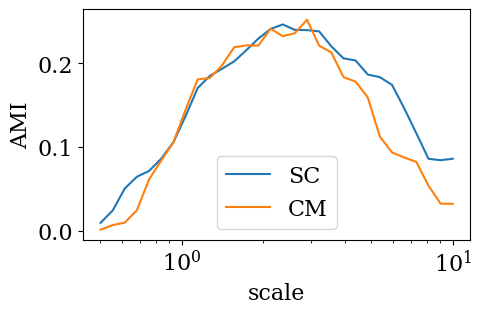

In [32]:
plt.figure(figsize=(5,3))

plt.plot(scales, sc_avg, label='SC')
plt.plot(scales, cc_avg, label='CM')

#plt.errorbar(scales, sc_avg, yerr=sc_std, label='SC')
#plt.errorbar(scales, cc_avg, yerr=cc_std, label='CM')

plt.xscale('log')

plt.xlabel('scale')
plt.ylabel('AMI')

plt.legend()

plt.show()

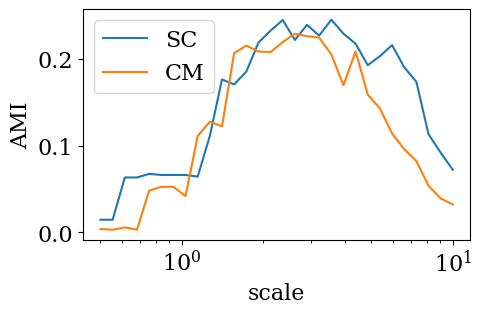

In [33]:
plt.figure(figsize=(5,3))

plt.plot(scales, sc_cons_scales, label='SC')
plt.plot(scales, cc_cons_scales, label='CM')

#plt.errorbar(scales, sc_avg, yerr=sc_std, label='SC')
#plt.errorbar(scales, cc_avg, yerr=cc_std, label='CM')

plt.xscale('log')

plt.xlabel('scale')
plt.ylabel('AMI')

plt.legend()

plt.show()

In [12]:
best_scale_sc = scales[np.argmax(sc_avg)]
best_scale_cc = scales[np.argmax(cc_avg)]

print(best_scale_sc, best_scale_cc)

2.357294229642178 2.8978037194176345


In [23]:
comms_sc = [community_detection(sc, 'leiden', best_scale_sc) for _ in range(nrep)]
comms_cc = [community_detection(communicability, 'leiden', best_scale_cc) for _ in range(nrep)]

# compute group consensus
cons_sc = cluster.find_consensus(np.column_stack(comms_sc))
cons_sc = np.array(cons_sc)-1
print(np.unique(cons_sc))

cons_cc = cluster.find_consensus(np.column_stack(comms_cc))
cons_cc = np.array(cons_cc)-1
print(np.unique(cons_cc))

[0 1 2 3 4 5 6 7]
[0 1 2 3 4 5 6 7 8 9]


In [26]:
np.savetxt('results/consensus_sc.txt', cons_sc)
np.savetxt('results/consensus_cc.txt', cons_cc)

In [ ]:
np.savetxt('results/avg_ami_sc.txt', sc_avg)
np.savetxt('results/avg_ami_cc.txt', cc_avg)

# Diffusion distance

In [85]:
diff = distance.diffusion_distance(sc, args=[1, 0.01], name='new_sc', title=None, comms=None, show=False)

DIFFUSION DISTANCE
- Compute laplacian...
1 0.01
- Compute average distance...


  0%|          | 0/100 [00:00<?, ?it/s]

- Compute hierarchical clustering with method ward...


# 

# Jacobian distance

In [52]:
dynamics = 'Neuronal'

B = 1
#C = 0

#Cs = [0.1, 0, -0.1]
#Rs = [0.1, 0.07, 0.05, 0.03, 0.01]
#Cs = [0.1]
#Rs = [0.08, 0.06]

#Cs = [0.1]
#Rs = [0.1, 0.07, 0.05, 0.03, 0.01]
#Cs = [0.]
#Rs = [1, 0.5, 0.1, 0.05]

Cs = [0.1, 0.01, 0, -0.01, -0.1]
Rs = [0.5, 0.1, 0.08, 0.05, 0.03, 0.01]

params = [[B, -0.11, 0.5]]

#params = [[B, C, R] for C in Cs for R in Rs]
print(params)

[[1, -0.11, 0.5]]


JACOBIAN DISTANCE
Dynamics: Neuronal
[1, -0.11, 0.5]


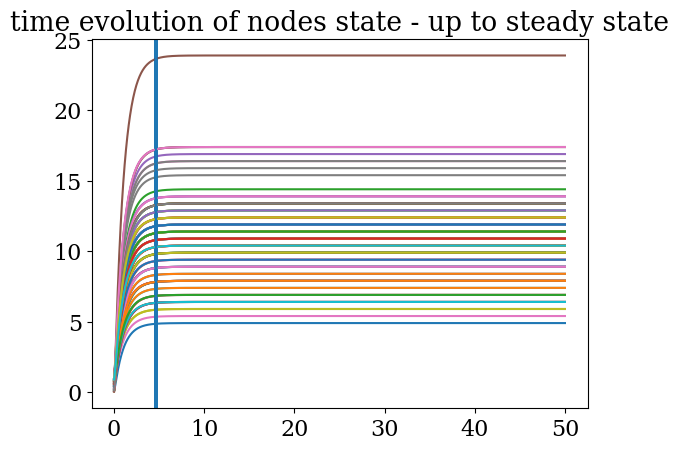

[1, -0.11, 0.5]
Normalizing jacobian - $\lambda_{max}$=1.0000418438264373
- Compute average distance...


  0%|          | 0/100 [00:00<?, ?it/s]

- Compute hierarchical clustering with method ward...


In [53]:
res_all = []

for param in params:
    res = distance.jacobian_distance(sc, dynamics, norm=True, args=param, name='new_sc', title=None, comms=None, show=False)
    res_all.append(res)

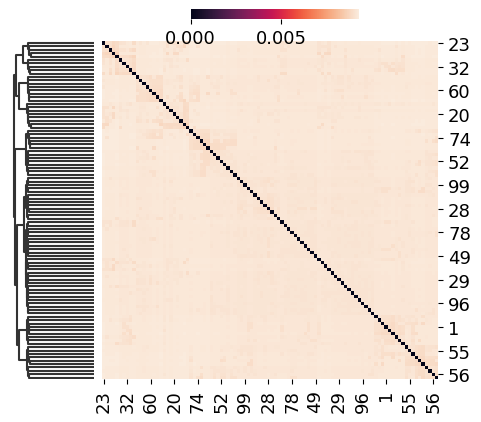

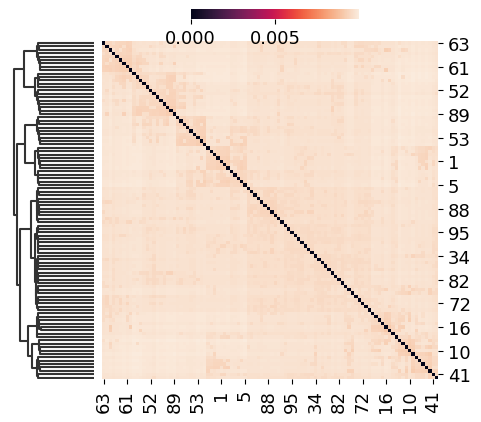

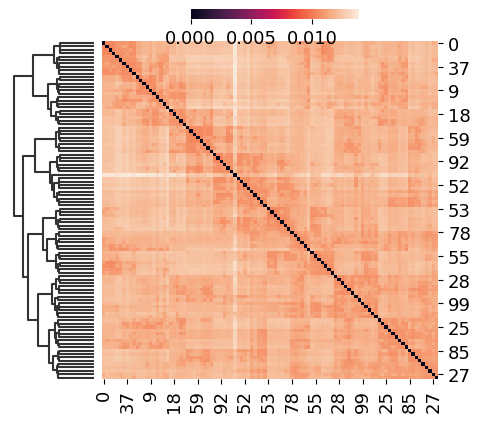

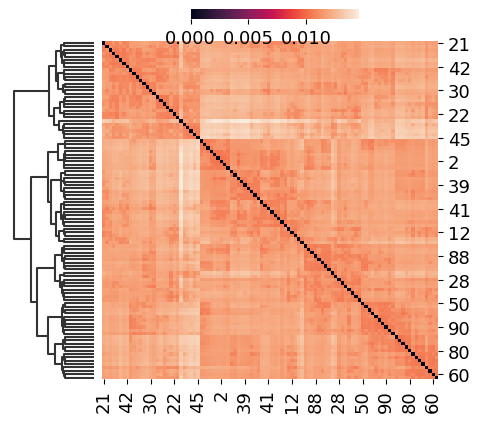

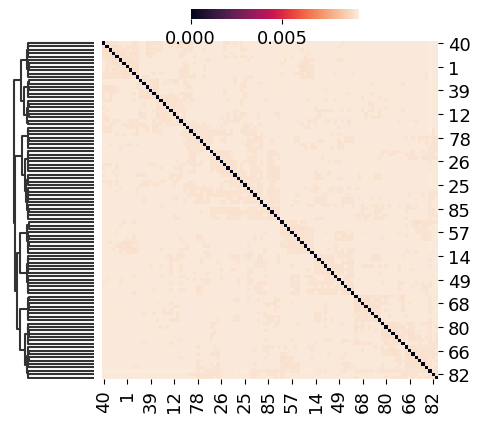

In [77]:
for i, res in enumerate(res_all[5:10]):
    plotter.plot_clustermap(res, figsize=(5,5))

# Load the results

In [34]:
diff = np.loadtxt('results/diffusion_new_sc.txt')

In [49]:

B = 1

#Cs = [0.1, 0, -0.1]
#Rs = [0.1, 0.07, 0.05, 0.03, 0.01]

#Cs = [0.1]
#Rs = [0.1, 0.07, 0.05, 0.03, 0.01]

#Cs = [0.1]
#Rs = [0.1, 0.07, 0.05, 0.03, 0.01]

Cs = [0.1, 0.01, 0, -0.01 -0.1]
Rs = [0.5, 0.1, 0.08, 0.05, 0.03, 0.01]


params = [[B, C, R] for C in Cs for R in Rs]
print(params)

res_all = [np.loadtxt(f'results/Neuronal_{param}_new_sc.txt') for param in params]

[[1, 0.1, 0.5], [1, 0.1, 0.1], [1, 0.1, 0.08], [1, 0.1, 0.05], [1, 0.1, 0.03], [1, 0.1, 0.01], [1, 0.01, 0.5], [1, 0.01, 0.1], [1, 0.01, 0.08], [1, 0.01, 0.05], [1, 0.01, 0.03], [1, 0.01, 0.01], [1, 0, 0.5], [1, 0, 0.1], [1, 0, 0.08], [1, 0, 0.05], [1, 0, 0.03], [1, 0, 0.01], [1, -0.11, 0.5], [1, -0.11, 0.1], [1, -0.11, 0.08], [1, -0.11, 0.05], [1, -0.11, 0.03], [1, -0.11, 0.01]]


In [50]:
ncomms = np.arange(2,40)

### Compute dendrogram
mylinkage = linkage(squareform(diff), method='ward')
### Compute communities = cut dendrogram
comms = [fcluster(mylinkage, criterion='maxclust', t=t) for t in ncomms]
    
### Compute index
infos_diff = [ami(tmp, comms_true) for tmp in comms]

### Store best comms diff
best_comms_diff = comms[np.argmax(infos_diff)]

# Compute community detection

In [37]:
ncomms = np.arange(2,40)

infos = np.zeros((len(params),len(ncomms)))

best_comms_jac = []

for i, res in enumerate(res_all):
    ### Compute dendrogram
    mylinkage = linkage(squareform(res), method='ward')
    ### Compute communities = cut dendrogram
    comms = [fcluster(mylinkage, criterion='maxclust', t=t) for t in ncomms]
    
    #to_print = [ np.unique(tmp, return_counts=True)[1].max() for tmp in comms]
    #print(to_print)
    
    ### Compute index
    infos[i] = [ami(tmp, comms_true) for tmp in comms]
    
    best_comms_jac.append(comms[np.argmax(infos[i])])
    
best_comms_jac = best_comms_jac[np.argmax(infos.max(axis=1))]

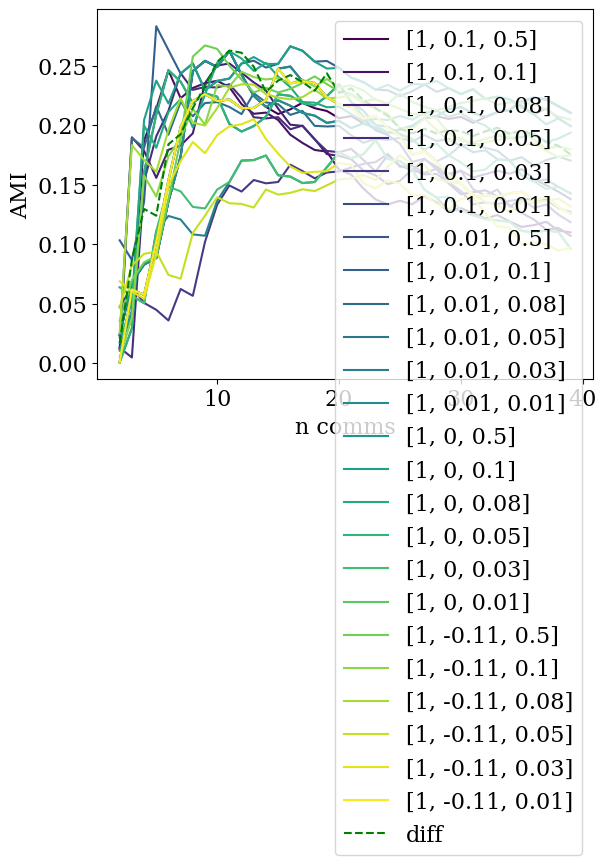

In [51]:
cmap = plt.get_cmap('viridis', len(params))

for i, info in enumerate(infos):
    plt.plot(ncomms, info, label=params[i], c=cmap(i))
    
plt.plot(ncomms, infos_diff, '--', label='diff', c='green')
#plt.plot(scales*4, comm_score, '--', label='communicability', c='red')
#plt.plot(scales*4, sc_score, '--', label='structural', c='blue')

plt.xlabel('n comms')
plt.ylabel('AMI')

plt.legend()
plt.show()

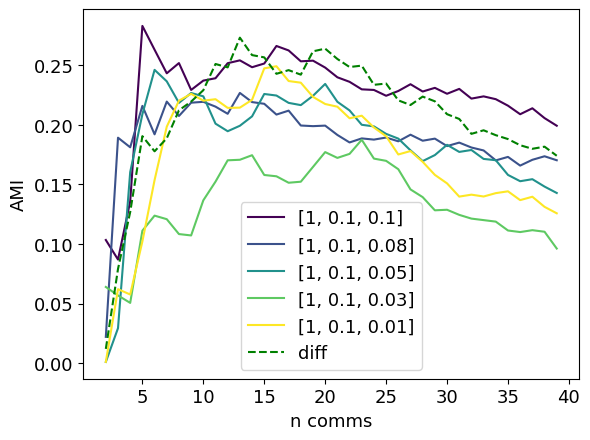

In [72]:
cmap = plt.get_cmap('viridis', len(params[5:10]))

for i, info in enumerate(infos[5:10]):
    plt.plot(ncomms, info, label=params[i], c=cmap(i))
    
plt.plot(ncomms, infos_diff, '--', label='diff', c='green')
#plt.plot(scales*4, comm_score, '--', label='communicability', c='red')
#plt.plot(scales*4, sc_score, '--', label='structural', c='blue')

plt.xlabel('n comms')
plt.ylabel('AMI')

plt.legend()
plt.show()

In [59]:
infos.shape

(24, 38)

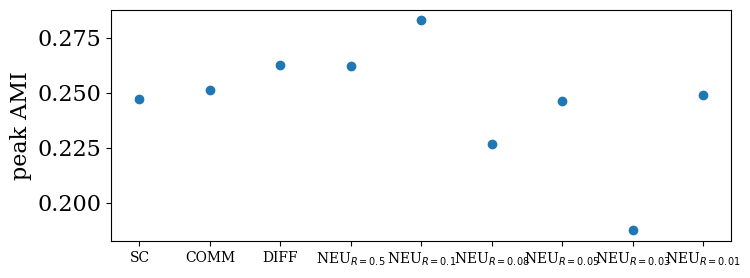

In [62]:
names = ['SC', 'COMM', 'DIFF', r'NEU$_{R=0.5}$', r'NEU$_{R=0.1}$', r'NEU$_{R=0.08}$', r'NEU$_{R=0.05}$', r'NEU$_{R=0.03}$', r'NEU$_{R=0.01}$']

final_infos = infos[6:12]

final_res = [np.max(sc_avg), np.max(cc_avg), np.max(infos_diff), final_infos.max(axis=1)]
final_res = np.hstack(final_res)

### Peak AMI
plt.figure(figsize=(8,3))
plt.plot(names, final_res, 'o')
plt.ylabel('peak AMI')
plt.xticks(fontsize=10)

plt.show()

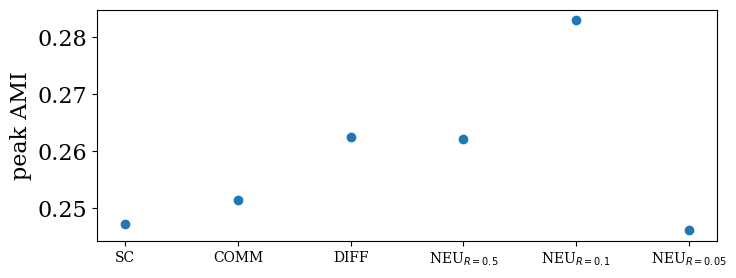

In [63]:
import seaborn as sns

names = ['SC', 'COMM', 'DIFF', r'NEU$_{R=0.5}$', r'NEU$_{R=0.1}$', r'NEU$_{R=0.05}$']

final_res = [np.max(sc_avg), np.max(cc_avg), np.max(infos_diff), final_infos.max(axis=1)[[0,1,3]]]
final_res = np.hstack(final_res)

### Peak AMI
plt.figure(figsize=(8,3))
plt.plot(names, final_res, 'o')
#plt.bar(names, final_res, 'o')
plt.ylabel('peak AMI')
plt.xticks(fontsize=10)

plt.show()

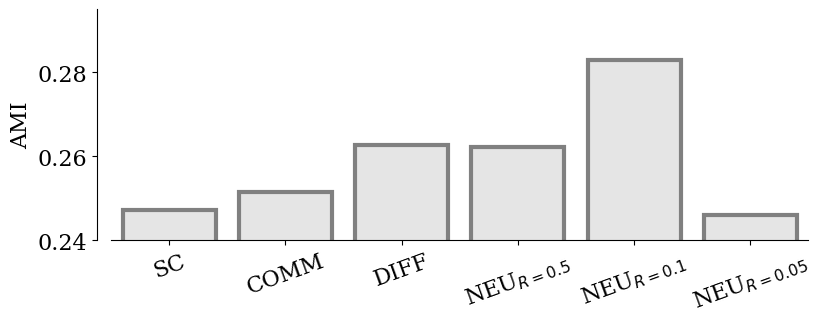

In [161]:
import seaborn as sns

names = ['SC', 'COMM', 'DIFF', r'NEU$_{R=0.5}$', r'NEU$_{R=0.1}$', r'NEU$_{R=0.05}$']

final_res = [np.max(sc_avg), np.max(cc_avg), np.max(infos_diff), final_infos.max(axis=1)[[0,1,3]]]
final_res = np.hstack(final_res)

### Peak AMI
plt.figure(figsize=(9,3))
sns.barplot(y=final_res, x=np.arange(len(final_res)), linewidth=3, edgecolor=".5", facecolor=(0, 0, 0, 0.1))
plt.ylim(0.24,0.295)
#plt.bar(names, final_res, 'o')
plt.xticks(np.arange(len(final_res)), names)
plt.ylabel('AMI')

plt.tick_params(axis='x', which='major', labelsize=16, rotation=20)

sns.despine(offset={'left':10,'right':0,'top':0,'bottom':0})

plt.savefig('figures/figure5_histogram.svg', transparent=True, bbox_inches='tight')
plt.show()

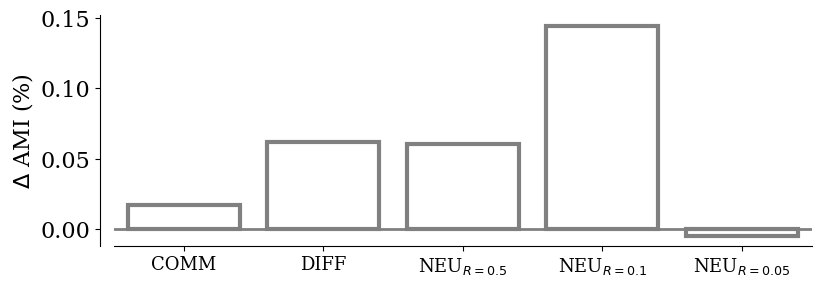

In [139]:
import seaborn as sns

names_relative = names[1:]

relative = (final_res[1:] - final_res[0]) / final_res[0]

### Peak AMI
plt.figure(figsize=(9,3))
sns.barplot(y=relative, x=np.arange(len(names_relative)), linewidth=3, edgecolor=".5", facecolor=(0, 0, 0, 0))
#plt.ylim(0.24,None)
#plt.bar(names, final_res, 'o')
plt.xticks(np.arange(len(names_relative)), names_relative)
plt.ylabel('$\Delta$ AMI (%)')
plt.xticks(fontsize=8)
plt.axhline(-1e-4, c='gray', zorder=-1, lw=2)

sns.despine(offset={'left':10,'right':0,'top':0,'bottom':0})

plt.tick_params(axis='x', which='major', labelsize=13)

plt.show()

In [35]:
np.savetxt('results/best_comm_diff.txt', best_comms_diff)
np.savetxt('results/best_comm_jac.txt', best_comms_jac)

np.savetxt('results/best_jac.txt', res_all[5])

# Figure for supplementary materials

In [ ]:
sc_avg = np.savetxt('results/avg_ami_sc.txt', sc_avg)
cc_avg = np.savetxt('results/avg_ami_cc.txt', cc_avg)

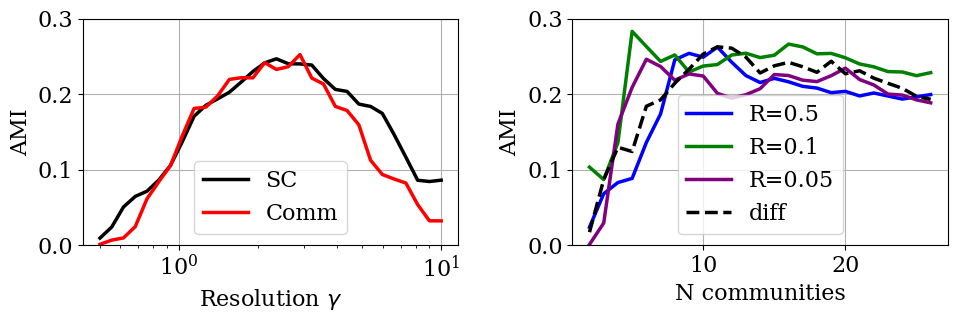

In [92]:
plt.figure(figsize=(10,3.5))
lw = 2.5

plt.subplot(1,2,1)

plt.plot(scales, sc_avg, '-', label='SC', c='k', ms=3, lw=lw)
plt.plot(scales, cc_avg, '-', label='Comm', c='r', ms=3, lw=lw)

plt.xscale('log')
plt.grid()

plt.xlabel(r'Resolution $\gamma$')
plt.ylabel('AMI')
plt.ylim(0, 0.3)

plt.legend()

plt.subplot(1,2,2)

to_plot = [0, 1, 3]
comms_max = 25
cs = ['blue', 'green', None, 'purple']

for i, info in enumerate(infos[6:12]):
    if i not in to_plot:
        continue
    plt.plot(ncomms[:comms_max], info[:comms_max], label='R='+str(params[i][-1]), c=cs[i], lw=lw)
    
plt.plot(ncomms[:comms_max], infos_diff[:comms_max], '--', label='diff', c='k', lw=lw)
#plt.plot(scales*4, comm_score, '--', label='communicability', c='red')
#plt.plot(scales*4, sc_score, '--', label='structural', c='blue')

plt.xlabel('N communities')
plt.ylabel('AMI')
plt.ylim(0, 0.3)

plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig('figures/figure_brain_model_selection.png', bbox_inches='tight', pad_inches=0.1, dpi=300)
plt.show()